# Exploring Brazilian E-commerce Data

In this notebook, we are going to explore a dataset related to e-commerce sales in Brazil and compare the following clustering Methods, __Kmeans__, __DBScan__ and __Meanshift__.

First, let's import the necessary Python libraries for data processing and visualization.

## Dataset Preparation

Next, we load a GeoJSON file that contains the map of Brazil's federal states.

In [31]:
import sys, json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn import preprocessing as pp
from sklearn.tree import _tree, DecisionTreeClassifier

from datetime import date
from tqdm.notebook import tqdm
from tensorflow import keras
from tqdm.keras import TqdmCallback

from sklearn.cluster import KMeans as km
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

pd.set_option('display.max_columns', None)

We now load various CSV files into pandas dataframes. Each file represents different aspects of the orders:

1. `olist_customers_dataset.csv`: Customer data.
2. `olist_order_items_dataset.csv`: Order items data.
3. `olist_order_payments_dataset.csv`: Payment data.
4. `olist_order_reviews_dataset.csv`: Customer reviews data.
5. `olist_orders_dataset.csv`: Orders data.
6. `olist_products_dataset.csv`: Products data.
7. `product_category_name_translation.csv`: Product categories translation data.

In [32]:
df = pd.read_csv('datasets/cleaned.csv')
df = df.drop(['order_purchase_timestamp_str'],axis=1)
print(df.columns)

Index(['order_purchase_timestamp', 'customer_code', 'price', 'payment_value',
       'review_score', 'freight_value', 'frequency', 'since_last_purchase'],
      dtype='object')


Now, we calculate and display the number of rows and columns in each dataframe to understand the size of our data.

## Functions

We create recurrent functions in order be able to call them in multiple situations. 

In this case we have the PCA to reduce the number of dimensions

In [33]:
def principalaxles(df):
    df = pp.StandardScaler().fit_transform(df)
    df = pd.DataFrame(data = df)
    pca = PCA()
    pca.fit(df)
    pca_data = pca.transform(df)
    per_var =  np.round(pca.explained_variance_ratio_*100, decimals = 1)
    labels =['PC' + str(x) for x in range(1, len(per_var)+1)]
    plt.bar(x=range(1,len(per_var)+1), height = per_var, tick_label = labels)
    plt.plot(np.arange(len(per_var))+1, per_var.cumsum(),c="red",marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Percentage Explained Variance")
    plt.title("Scree plot")
    plt.show(block=False) 
    pca_df = pd.DataFrame(pca_data, columns=labels)
    return pca_df, per_var

The elbow method consists in calculating the variance for every number of clusters if applied to the data. Is is common practice for the KMeans Model to choose the number of clusters at the inflexion point (elbow) in the graph as the best tradeoff between variance and plausibility of the individual clusters

In [34]:
def elbow(method,X):
    tab = []
    r = range(1,40)
    for i in tqdm(r):
        kmeans = km(n_clusters = i)
        kmeans.fit(pca_df)
        tab.append(kmeans.inertia_)

    plt.plot(r,tab)
    plt.title('Elbow Method')
    plt.xlabel('Nb of Clusters')
    plt.ylabel('Inertia')
    plt.show()

Here we have a model agnostic clustering function which we can feed many models in order to compare them

In [35]:
def clustering(model,X):
    clustering = model.fit(X)
    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    d = [str(model), n_clusters_, silhouette_score(X, labels, metric='euclidean', sample_size=None, random_state=None)] 
    evaluation_table.append(d)
    return labels

And finally we need a function to plot the results

In [36]:
def plot(X,labels):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(X.iloc[:,0],X.iloc[:,1], c=labels)
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    plt.show()

## Essais

### Clustering avec Kmeans avant PCA

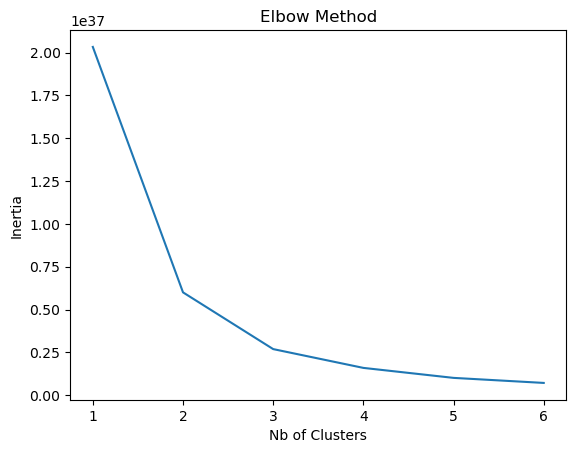

In [37]:
tab = []
for i in range(1,7):
    kmeans = km(n_clusters = i , n_init=10)
    kmeans.fit(df)
    tab.append(kmeans.inertia_)
    
plt.plot(range(1,7),tab)
plt.title('Elbow Method')
plt.xlabel('Nb of Clusters')
plt.ylabel('Inertia')
plt.show()

In [38]:
evaluation_table = []

In [39]:
clusters = clustering(km(n_clusters=2 , n_init=10),df)
evaluation_table = []

## PCA

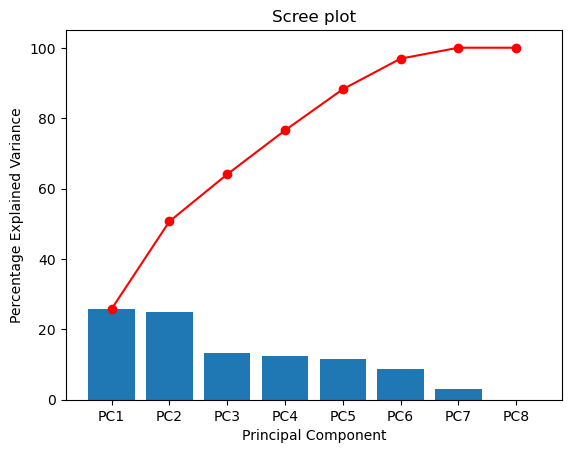

In [40]:
pca_df, per_var = principalaxles(df)

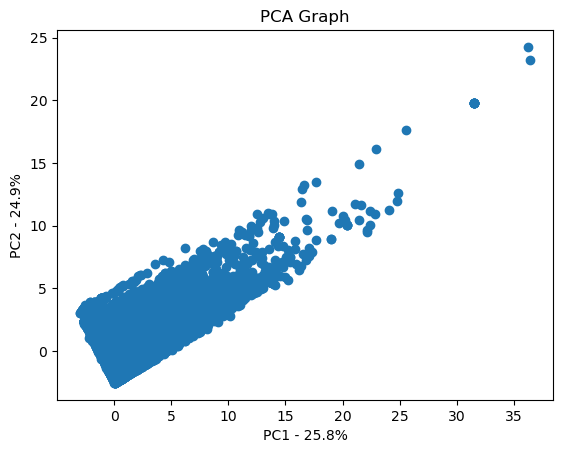

In [41]:
plt.scatter(pca_df['PC1'],pca_df['PC2'])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.title('PCA Graph')
plt.show()

## Clustering après PCA

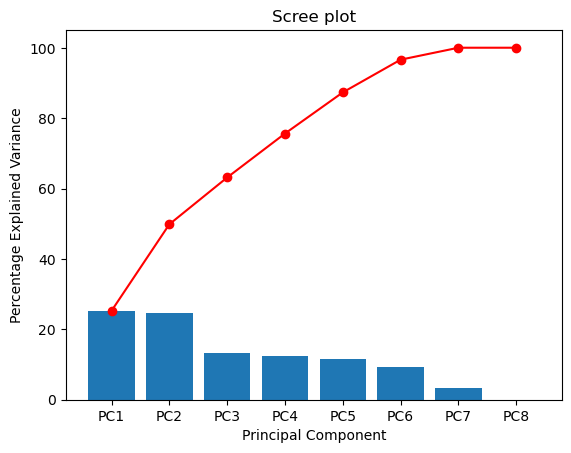

In [42]:
evaluation_table = []

df_sample = df.sample(frac=0.1, random_state=42)
pca_df_sample, per_var = principalaxles(df_sample)
clusters_km=clustering(km(n_clusters=3, n_init=10),df_sample)
clusters_meanshift = clustering(MeanShift(bandwidth=12),pca_df_sample)
clusters_dbscan = clustering(DBSCAN(eps=5, min_samples=2),pca_df_sample)
clusters_ac = clustering(AgglomerativeClustering(n_clusters=3),pca_df_sample)
evaluation_table = pd.DataFrame(data=evaluation_table, columns=['Algorithm','Nb of Clusters','Silhouette Score'])#change order


In [43]:
evaluation_table.sort_values(by='Silhouette Score',ascending =False)

,Algorithm,Nb of Clusters,Silhouette Score
2,"DBSCAN(eps=5, min_samples=2)",4,0.863257
1,MeanShift(bandwidth=12),5,0.840996
0,"KMeans(n_clusters=3, n_init=10)",3,0.574137
3,AgglomerativeClustering(n_clusters=3),3,0.212768


## Cluster Analysis

### KMeans

In [44]:
df_sample['Cluster_K_Means'] = clusters_km

In [45]:
df_sample.groupby('Cluster_K_Means').count()/df_sample['customer_code'].count().sum()


,order_purchase_timestamp,customer_code,price,payment_value,review_score,freight_value,frequency,since_last_purchase
Cluster_K_Means,,,,,,,,
0,0.377562,0.377562,0.377562,0.377562,0.377562,0.377562,0.377562,0.377562
1,0.244616,0.244616,0.244616,0.244616,0.244616,0.244616,0.244616,0.244616
2,0.377822,0.377822,0.377822,0.377822,0.377822,0.377822,0.377822,0.377822


In [46]:
df_sample.head(20)

,order_purchase_timestamp,customer_code,price,payment_value,review_score,freight_value,frequency,since_last_purchase,Cluster_K_Means
80929,1530482505000000000,56178,855.00,874.33,5,19.33,1,1856.0,0
98263,1509449568000000000,51362,106.50,337.50,2,6.00,3,2099.0,2
12492,1515844329000000000,84159,129.00,147.15,5,18.15,1,2025.0,2
31032,1533543659000000000,51632,64.80,78.83,4,14.03,1,1821.0,0
96097,1511530640000000000,14550,79.90,283.06,1,21.34,3,2075.0,2
68686,1507935880000000000,20550,143.00,181.55,5,38.55,1,2117.0,2
30813,1515749574000000000,25338,49.90,67.50,5,17.60,1,2027.0,2
78093,1532013691000000000,37202,72.00,190.60,3,23.30,2,1838.0,0
64576,1491297571000000000,45498,99.90,116.75,5,16.85,2,2310.0,1
49137,1517865373000000000,6581,135.00,149.70,3,14.70,1,2002.0,2


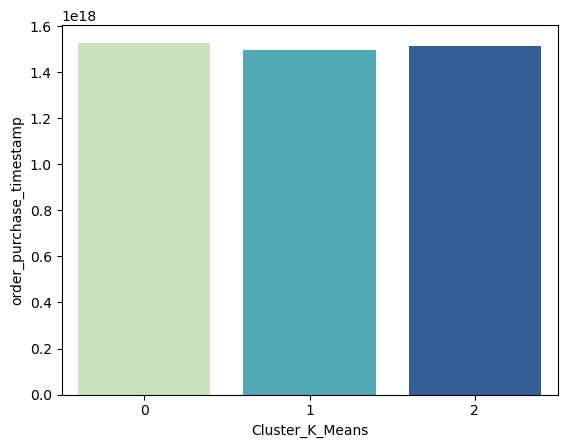

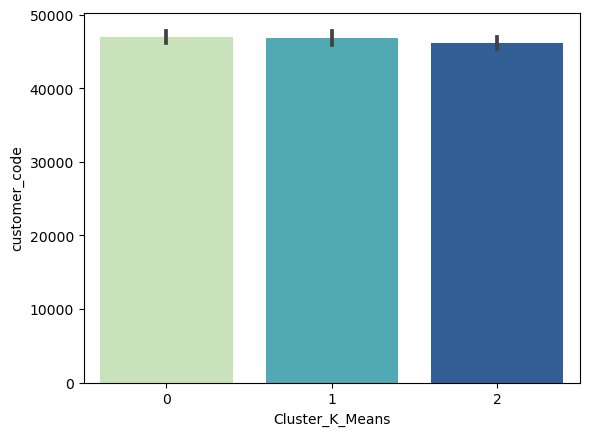

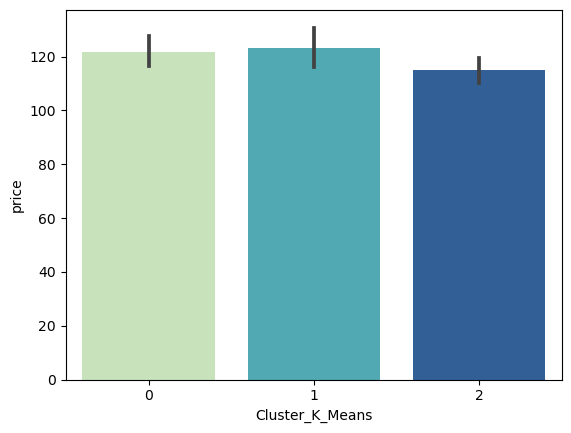

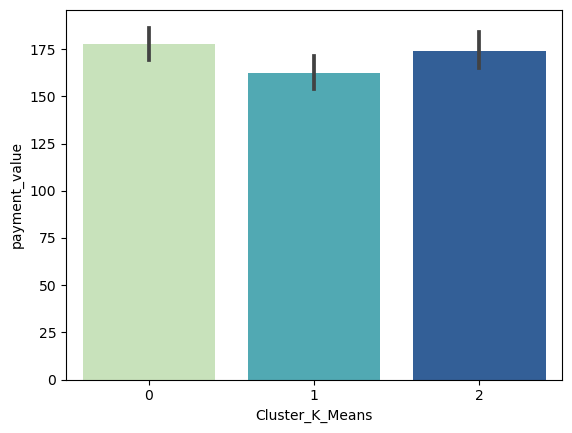

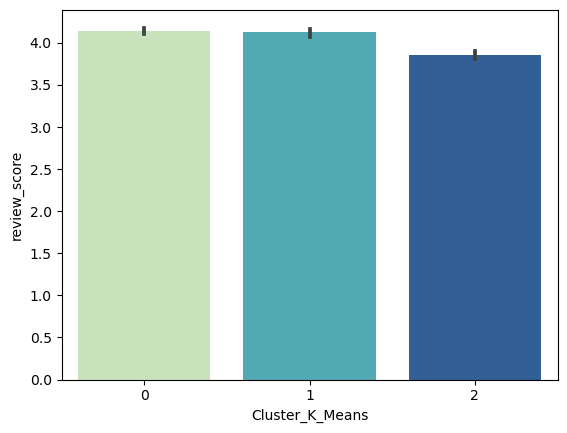

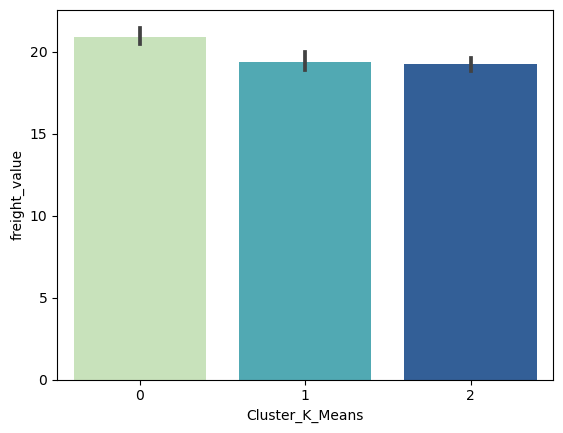

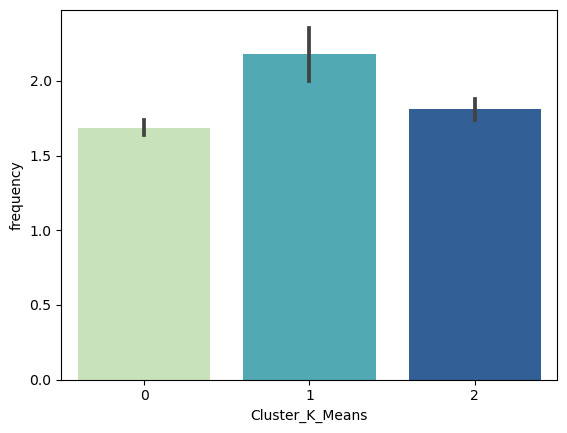

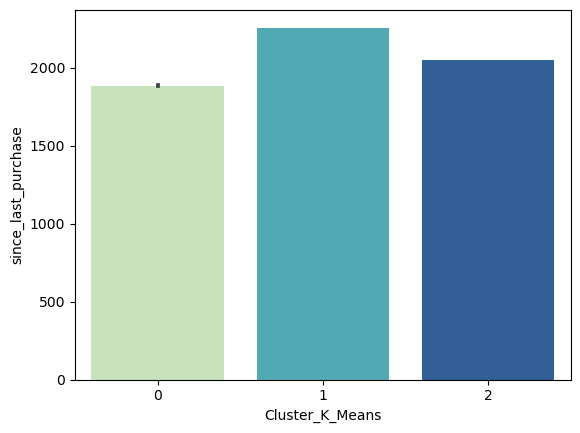

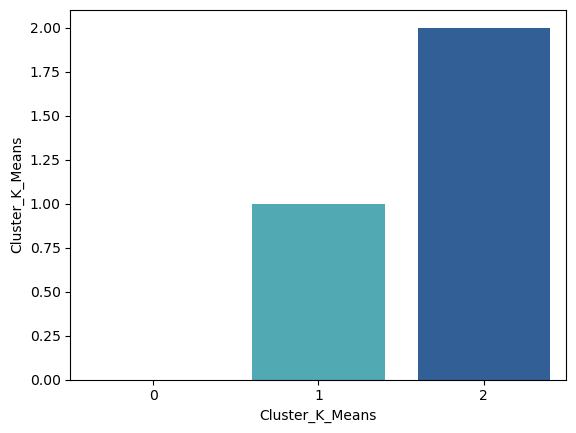

In [47]:
for feature in df_sample.columns:
    sns.barplot(data=df_sample, x='Cluster_K_Means', y=feature, palette='YlGnBu')
    plt.show()

In [48]:
ca=df_sample[['payment_value','Cluster_K_Means']].groupby('Cluster_K_Means').sum().sort_values(by='payment_value', ascending = False)
ca['%CA']=np.round(ca['payment_value']/ca['payment_value'].sum(),5)
ca.reset_index(inplace=True)
ca.head()

,Cluster_K_Means,payment_value,%CA
0,0,774860.39,0.38848
1,2,760490.34,0.38127
2,1,459269.70,0.23025


In [49]:
clientsparcluster=df_sample[['Cluster_K_Means','customer_code']].groupby('Cluster_K_Means').count().sort_values(by='customer_code', ascending = False)
clientsparcluster

,customer_code
Cluster_K_Means,
2,4368
0,4365
1,2828


### DBScan

In [50]:
evaluation_table=[]

In [51]:
df_sample['Cluster_DB'] = clusters_dbscan

In [52]:
df_sample.head(20)

,order_purchase_timestamp,customer_code,price,payment_value,review_score,freight_value,frequency,since_last_purchase,Cluster_K_Means,Cluster_DB
80929,1530482505000000000,56178,855.00,874.33,5,19.33,1,1856.0,0,0
98263,1509449568000000000,51362,106.50,337.50,2,6.00,3,2099.0,2,0
12492,1515844329000000000,84159,129.00,147.15,5,18.15,1,2025.0,2,0
31032,1533543659000000000,51632,64.80,78.83,4,14.03,1,1821.0,0,0
96097,1511530640000000000,14550,79.90,283.06,1,21.34,3,2075.0,2,0
68686,1507935880000000000,20550,143.00,181.55,5,38.55,1,2117.0,2,0
30813,1515749574000000000,25338,49.90,67.50,5,17.60,1,2027.0,2,0
78093,1532013691000000000,37202,72.00,190.60,3,23.30,2,1838.0,0,0
64576,1491297571000000000,45498,99.90,116.75,5,16.85,2,2310.0,1,0
49137,1517865373000000000,6581,135.00,149.70,3,14.70,1,2002.0,2,0


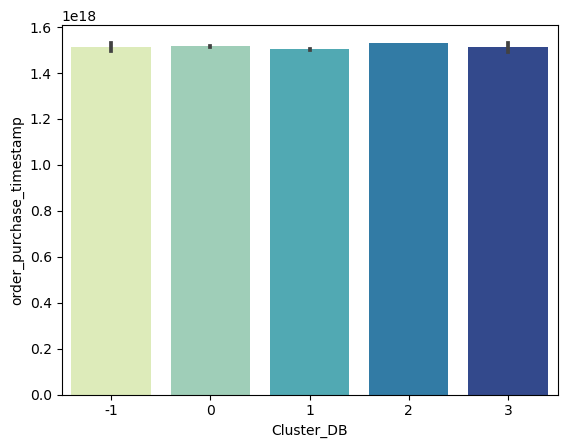

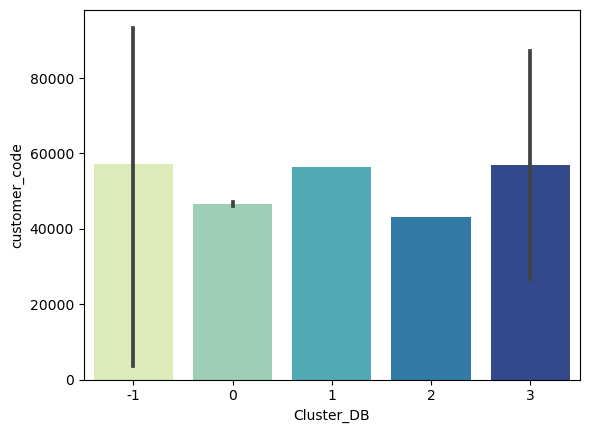

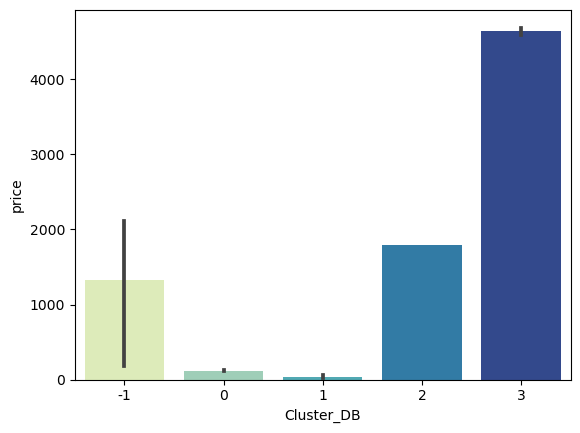

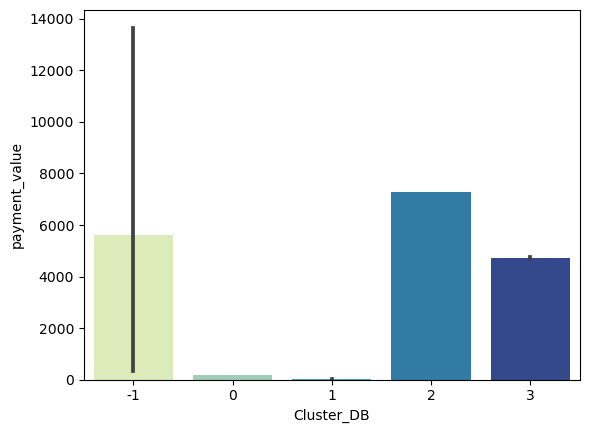

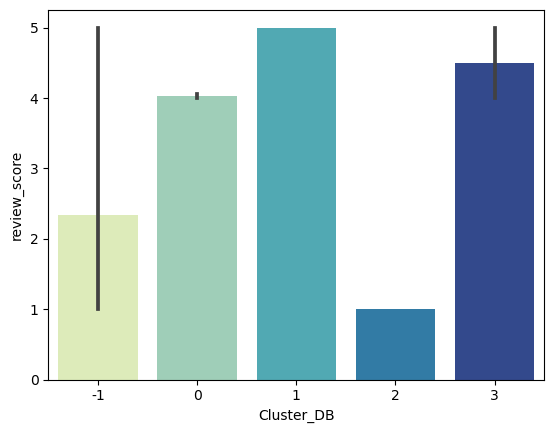

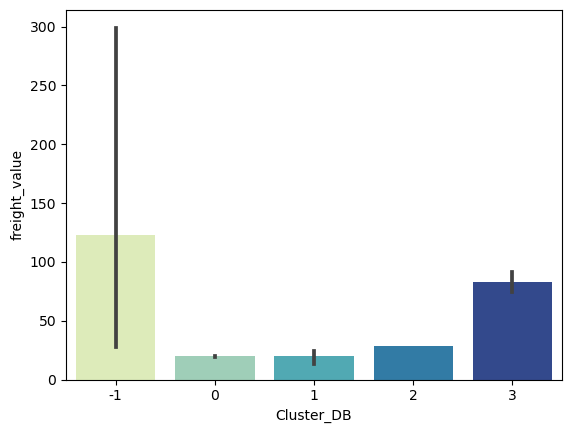

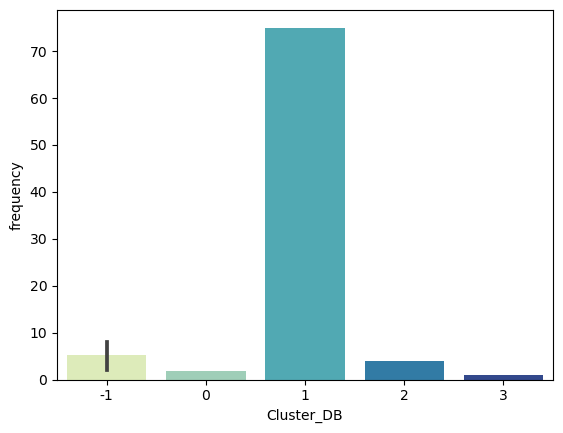

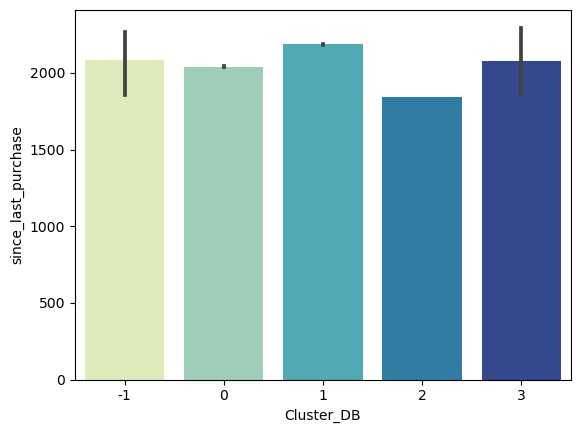

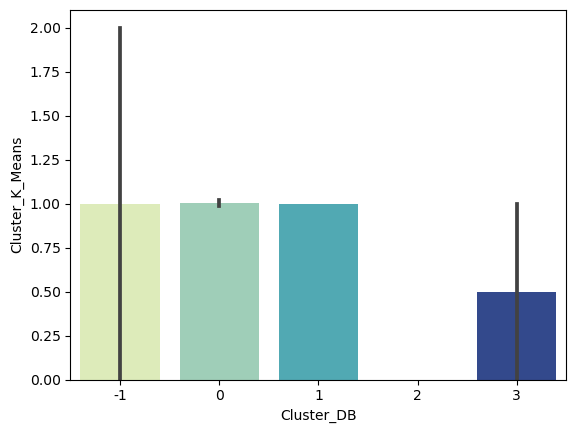

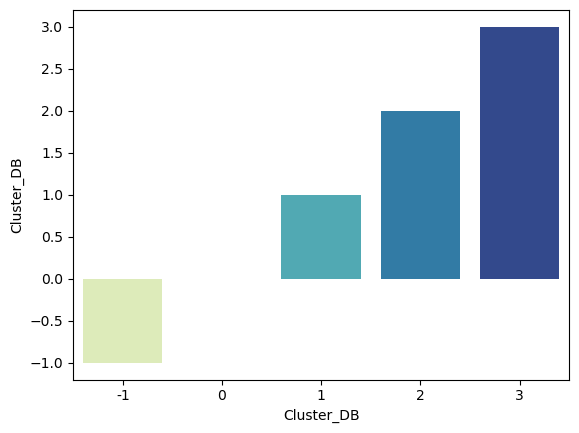

In [53]:
for feature in df_sample.columns:
    sns.barplot(data=df_sample, x='Cluster_DB', y=feature, palette='YlGnBu')
    plt.show()

In [54]:
ca=df_sample[['payment_value','Cluster_DB']].groupby('Cluster_DB').sum().sort_values(by='payment_value', ascending = False)
ca['%CA']=np.round(ca['payment_value']/ca['payment_value'].sum(),5)
ca.reset_index(inplace=True)
ca.head()

,Cluster_DB,payment_value,%CA
0,0,1953726.55,0.97950
1,-1,16859.85,0.00845
2,2,14549.76,0.00729
3,3,9446.12,0.00474
4,1,38.15,0.00002


In [55]:
clientsparcluster=df_sample[['Cluster_DB','customer_code']].groupby('Cluster_DB').count().sort_values(by='customer_code', ascending = False)
clientsparcluster

,customer_code
Cluster_DB,
0,11546
1,8
-1,3
2,2
3,2


### Meanshift

In [56]:
df_sample['Cluster_Meanshift'] = clusters_meanshift

In [57]:
df_sample.head(20)

,order_purchase_timestamp,customer_code,price,payment_value,review_score,freight_value,frequency,since_last_purchase,Cluster_K_Means,Cluster_DB,Cluster_Meanshift
80929,1530482505000000000,56178,855.00,874.33,5,19.33,1,1856.0,0,0,0
98263,1509449568000000000,51362,106.50,337.50,2,6.00,3,2099.0,2,0,0
12492,1515844329000000000,84159,129.00,147.15,5,18.15,1,2025.0,2,0,0
31032,1533543659000000000,51632,64.80,78.83,4,14.03,1,1821.0,0,0,0
96097,1511530640000000000,14550,79.90,283.06,1,21.34,3,2075.0,2,0,0
68686,1507935880000000000,20550,143.00,181.55,5,38.55,1,2117.0,2,0,0
30813,1515749574000000000,25338,49.90,67.50,5,17.60,1,2027.0,2,0,0
78093,1532013691000000000,37202,72.00,190.60,3,23.30,2,1838.0,0,0,0
64576,1491297571000000000,45498,99.90,116.75,5,16.85,2,2310.0,1,0,0
49137,1517865373000000000,6581,135.00,149.70,3,14.70,1,2002.0,2,0,0


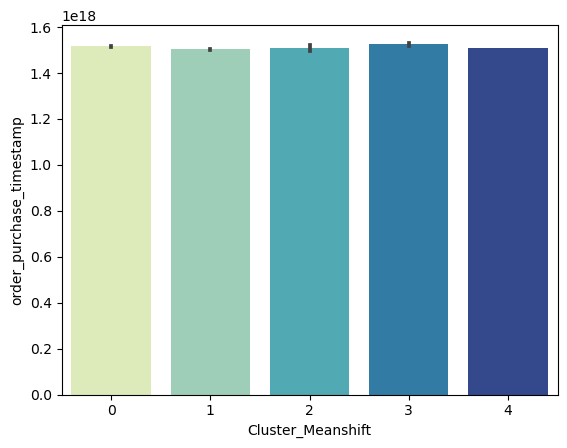

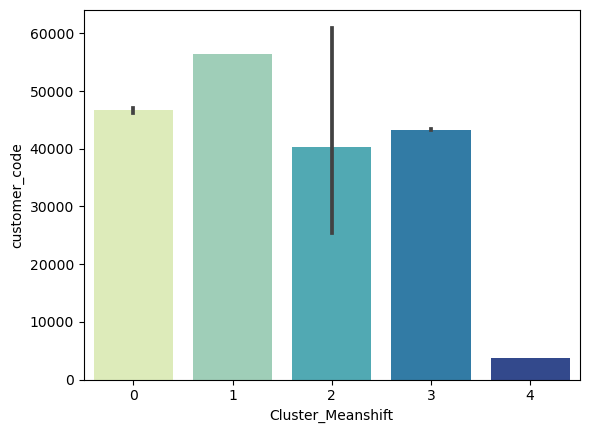

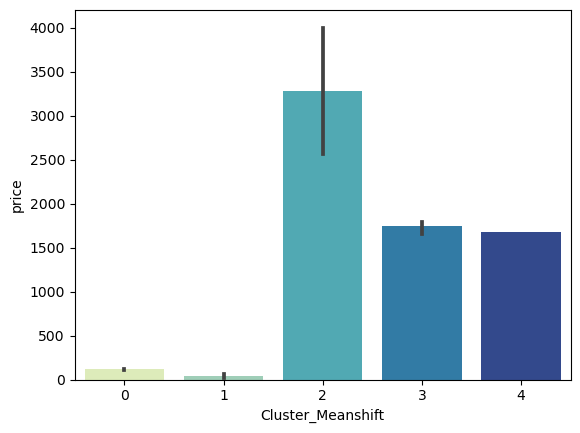

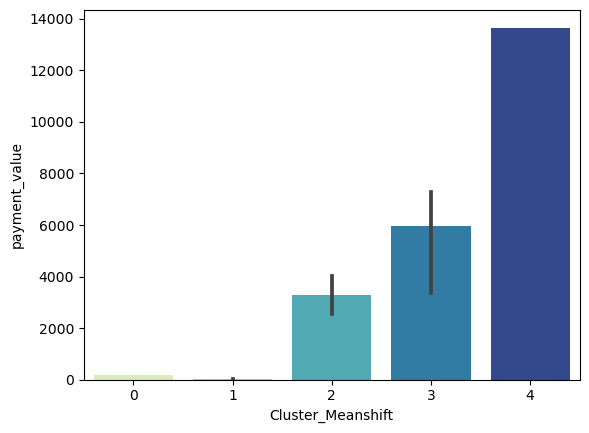

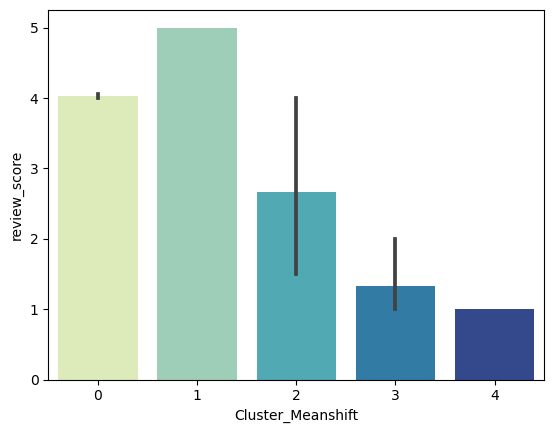

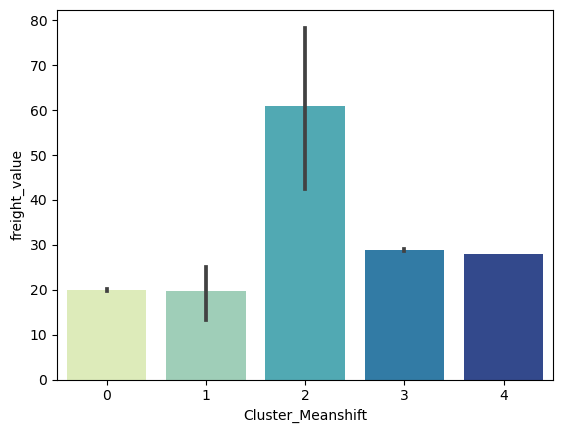

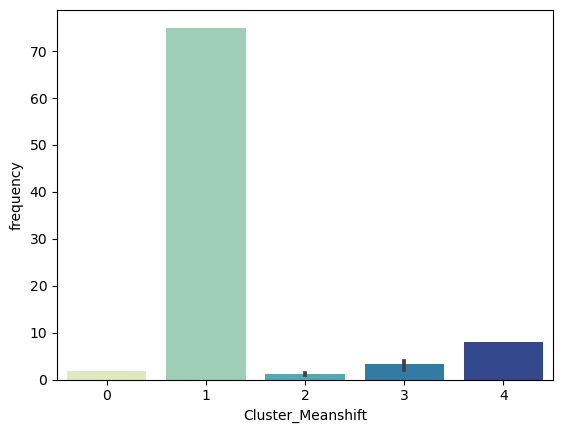

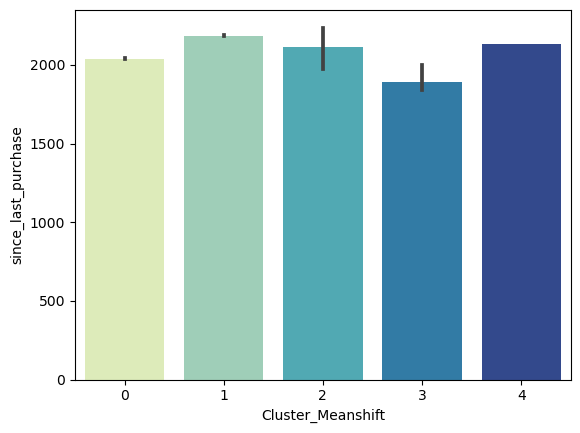

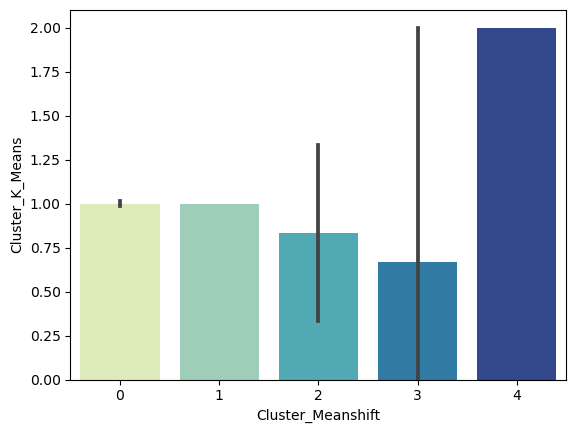

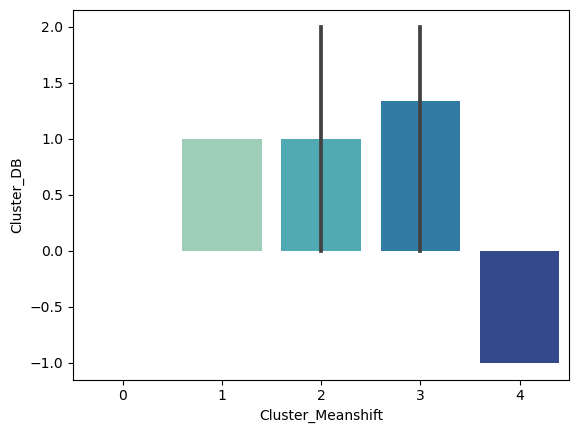

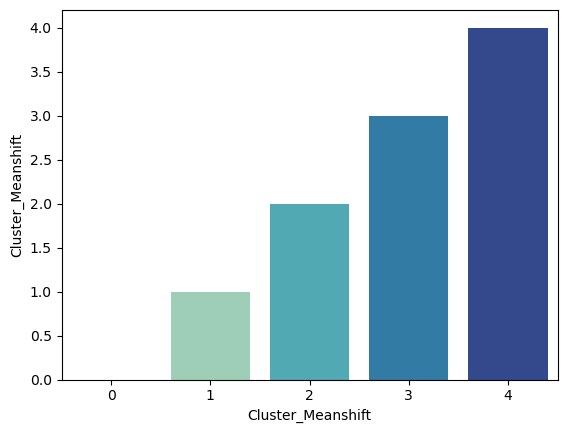

In [58]:
for feature in df_sample.columns:
    sns.barplot(data=df_sample, x='Cluster_Meanshift', y=feature, palette='YlGnBu')
    plt.show()

In [59]:
ca=df_sample[['payment_value','Cluster_Meanshift']].groupby('Cluster_Meanshift').sum().sort_values(by='payment_value', ascending = False)
ca['%CA']=np.round(ca['payment_value']/ca['payment_value'].sum(),3)
ca.reset_index(inplace=True)
ca.head()

,Cluster_Meanshift,payment_value,%CA
0,0,1943229.18,0.974
1,2,19781.02,0.010
2,3,17908.00,0.009
3,4,13664.08,0.007
4,1,38.15,0.000


In [60]:
clientsparcluster=df_sample[['Cluster_Meanshift','customer_code']].groupby('Cluster_Meanshift').count().sort_values(by='customer_code', ascending = False)
clientsparcluster

,customer_code
Cluster_Meanshift,
0,11543
1,8
2,6
3,3
4,1
